In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    

                                                     
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

# added Imports For Multiprocessing
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env import VecMonitor

# added Imports for Tensorboard Analysis
%load_ext tensorboard
import tensorflow as tf
import datetime

ModuleNotFoundError: No module named 'fenics'

# Formalising the Problem
Beim Durchführen einer Topologieoptimierung geht es darum folgende Funktion zu mimimieren

$$\begin{aligned}\mathbf{\mathit{F}} \big( \mathbf{u}(\rho), \rho \big) = \int_\Omega^\Omega{f(\mathbf{u}(\rho), \rho)}\,\mathrm{d}V\end{aligned}$$


mit Einbezug der Funktionen
$$\begin{aligned}G_{0}(\rho)=\int_\Omega^\Omega\rho\mathrm{d}V-V_{0}\end{aligned}\leq 0$$
und
$$\begin{aligned}\rho(x) \in \{0,1\}\,   \end{aligned} \forall x \in \Omega$$





Der zu trainierende Agent benötigt einen Zustandsraum, mithilfe dessen der zu trainierende Agent alle möglichen Beobachtungen innerhalb der Trainingsumgebung sehen kann.\
Zur Repräsentation des Zustandsraums des Grids sollte eine NxNx3 Matrix verwendet werden
$$\begin{aligned}O_{d,x, y}\end{aligned}$$
Die ersten beiden Indizes $x,y$ repräsentieren so die Koordinaten der einzelnen Punkte, 
und der letzte index funktioniert folgendermaßen:
- für d = 0 zeigt die Matrix die Spannung jedes Elements. Berechnet wird diese durch das Inverse der normalisierten Von Mises Formel:
    $$\sigma_{\mathit{VM}} = \sqrt{\sigma_{x}^{2} + \sigma_{y}^{2} - \sigma_{x}\sigma_{y} + 3\tau_{x,y}}$$ 
    Also:
    $$O_{0,x,y} = \left(\frac{\sigma_{\mathit{VM,x,y}}}{\sigma_{\mathit{VM,max}}}\right)^{-1}$$
- für d = 1 enspricht $O_{1,x,y}$ einer Boolschen repräsentation, ob der Knoten an Position $(x,y)$ nach den Dirichlet-Randbedingungen fixiert ist oder nicht
    Also:
    $$O_{1,x,y} \in \{1,0\}\,   \forall (x,y)$$
- für d = 1 enspricht $O_{3,x,y}$ analog einer boolschen repräsentation, ob der Knoten eine Kraft erfährt
    Also auch:
    $$O_{3,x,y} \in \{1,0\}\,   \forall (x,y)$$





# Objective Function
$\mathbf{\mathit{F}} \big( \mathbf{u}(\rho), \rho \big) = \int_\Omega^\Omega{f\big(\mathbf{u}(\rho), \rho\big)}\,\mathrm{d}V$

In [ ]:
def objective(rho, f, u, volume):
    # Berechne u als Funktion von rho, hier vereinfacht dargestellt
    u_rho = u(rho)
    return np.sum(f(u_rho, rho) * volume)

# Compliance Function


In [ ]:
def volume_constraint(rho, volume, V0):
    return V0 - np.sum(rho * volume)

In [2]:
def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

e = 200e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio

stiffness_matrix = get_stiffness_matrix(e, nu)
print(stiffness_matrix)

[[ 9.89010989e+10  3.57142857e+10 -6.04395604e+10 -2.74725275e+09
  -4.94505495e+10 -3.57142857e+10  1.09890110e+10  2.74725275e+09]
 [ 3.57142857e+10  9.89010989e+10  2.74725275e+09  1.09890110e+10
  -3.57142857e+10 -4.94505495e+10 -2.74725275e+09 -6.04395604e+10]
 [-6.04395604e+10  2.74725275e+09  9.89010989e+10 -3.57142857e+10
   1.09890110e+10 -2.74725275e+09 -4.94505495e+10  3.57142857e+10]
 [-2.74725275e+09  1.09890110e+10 -3.57142857e+10  9.89010989e+10
   2.74725275e+09 -6.04395604e+10  3.57142857e+10 -4.94505495e+10]
 [-4.94505495e+10 -3.57142857e+10  1.09890110e+10  2.74725275e+09
   9.89010989e+10  3.57142857e+10 -6.04395604e+10 -2.74725275e+09]
 [-3.57142857e+10 -4.94505495e+10 -2.74725275e+09 -6.04395604e+10
   3.57142857e+10  9.89010989e+10  2.74725275e+09  1.09890110e+10]
 [ 1.09890110e+10 -2.74725275e+09 -4.94505495e+10  3.57142857e+10
  -6.04395604e+10  2.74725275e+09  9.89010989e+10 -3.57142857e+10]
 [ 2.74725275e+09 -6.04395604e+10  3.57142857e+10 -4.94505495e+10
  -

In [ ]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

In [ ]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [ ]:
def calculate_von_mises_stress(stiffness_matrix, strain):
    stresses = anp.dot(stiffness_matrix, strain)
    
    sigma_x = stresses[0]
    sigma_y = stresses[1]
    tau_xy = stresses[2]

    von_mises_stress = anp.sqrt(sigma_x**2 
                                - sigma_x*sigma_y 
                                + sigma_y**2 
                                + 3*tau_xy**2)

    return von_mises_stress

$$\sigma_{\mathit{VM}} = \sqrt{\sigma_{x}^{2} + \sigma_{y}^{2} - \sigma_{x}\sigma_{y} + 3\tau_{x,y}}$$ 

In [ ]:
def calculate_stress(stiffness_matrix, strain, obs):
    stress_matrix= obs[:,:,0]
    for x in np.nditer(stress_matrix, op_flags=['readwrite']):
    if x > 0:
        x[...] *= calculate_von_mises_stress()
    return stress_matrix

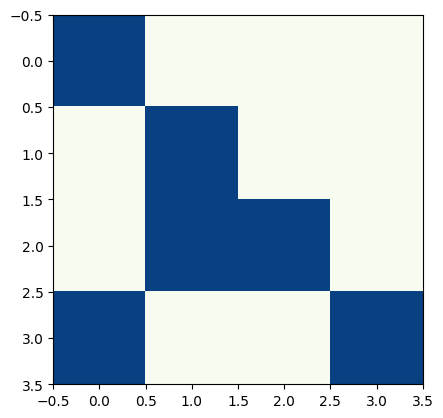

In [27]:
Z = [[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 1, 1, 0],
     [1, 0, 0, 1]]

fig, ax = plt.subplots()
ax.imshow(Z, cmap='GnBu')

plt.show()